In [29]:
#Импортируем библиотеки
import numpy as np
import pandas as pd

In [30]:
data = pd.read_csv('Churn_Modelling.csv')

In [31]:
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [32]:
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

data['CreditScore_Bins'] = pd.qcut(data['CreditScore'], 5, 
                                   labels=['CS_lt_566', 'CS_556_to_627', 'CS_627_to_678', 'CS_678_to_735', 'CS_gt_735'])
data['Age_Bins'] = pd.qcut(data['Age'], 5, 
                           labels=['Age_lt_31', 'Age_31_to_35', 'Age_35_to_40', 'Age_40_to_46', 'Age_gt_46'])
data['Balance_Bins'] = pd.qcut(data['Balance'], 5, 
                               labels=['Bal_lt_73080', 'Bal_73080_to_110138', 'Bal_110138_to_133710', 'Bal_gt_133710'],
                               duplicates='drop')
data['Salary_Bins'] = pd.qcut(data['EstimatedSalary'], 5, 
                              labels=['Sal_lt_41050', 'Sal_41050_to_80238', 'Sal_80238_to_119710', 'Sal_119710_to_159836', 'Sal_159836_to_199992'])

data.drop(['CreditScore', 'Age', 'Balance', 'EstimatedSalary'], axis=1, inplace=True)

In [33]:
data

,Geography,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Exited,CreditScore_Bins,Age_Bins,Balance_Bins,Salary_Bins
0,France,Female,2,1,1,1,1,CS_556_to_627,Age_40_to_46,Bal_lt_73080,Sal_80238_to_119710
1,Spain,Female,1,1,0,1,0,CS_556_to_627,Age_40_to_46,Bal_73080_to_110138,Sal_80238_to_119710
2,France,Female,8,3,1,0,1,CS_lt_566,Age_40_to_46,Bal_gt_133710,Sal_80238_to_119710
3,France,Female,1,2,0,0,0,CS_678_to_735,Age_35_to_40,Bal_lt_73080,Sal_80238_to_119710
4,Spain,Female,2,1,1,1,0,CS_gt_735,Age_40_to_46,Bal_110138_to_133710,Sal_41050_to_80238
...,...,...,...,...,...,...,...,...,...,...,...
9995,France,Male,5,2,1,0,0,CS_gt_735,Age_35_to_40,Bal_lt_73080,Sal_80238_to_119710
9996,France,Male,10,1,1,1,0,CS_lt_566,Age_31_to_35,Bal_lt_73080,Sal_80238_to_119710
9997,France,Female,7,1,0,1,1,CS_678_to_735,Age_35_to_40,Bal_lt_73080,Sal_41050_to_80238
9998,Germany,Male,3,2,1,0,1,CS_gt_735,Age_40_to_46,Bal_73080_to_110138,Sal_80238_to_119710


In [34]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [35]:
for col in data.columns:
    if col == 'Exited': continue
    else:
        print('WoE and IV for column: {}'.format(col))
        df, iv = calculate_woe_iv(data, col, 'Exited')
        print(df)
        print('IV score: {:.2f}'.format(iv))
        print('\n')

WoE and IV for column: Geography
     Value   All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
2  Germany  2509  1695  814    0.212859   0.399607 -0.629850  0.117623
1    Spain  2477  2064  413    0.259199   0.202749  0.245626  0.013865
0   France  5014  4204  810    0.527942   0.397644  0.283430  0.036930
IV score: 0.17


WoE and IV for column: Gender
    Value   All  Good   Bad  Distr_Good  Distr_Bad       WoE        IV
0  Female  4543  3404  1139    0.427477   0.559156 -0.268527  0.035359
1    Male  5457  4559   898    0.572523   0.440844  0.261361  0.034416
IV score: 0.07


WoE and IV for column: Tenure
    Value   All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
10      0   413   318   95    0.039935   0.046637 -0.155153  0.001040
1       1  1035   803  232    0.100841   0.113893 -0.121710  0.001589
9       9   984   771  213    0.096823   0.104566 -0.076931  0.000596
6       3  1009   796  213    0.099962   0.104566 -0.045021  0.000207
8       5  1012   803  209

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


           Value   All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
1      CS_lt_566  2010  1558  452    0.195655   0.221895 -0.125852  0.003302
0  CS_556_to_627  2020  1599  421    0.200804   0.206676 -0.028827  0.000169
3      CS_gt_735  1979  1573  406    0.197539   0.199313 -0.008941  0.000016
4  CS_627_to_678  2010  1615  395    0.202813   0.193913  0.044877  0.000399
2  CS_678_to_735  1981  1618  363    0.203190   0.178203  0.131216  0.003279
IV score: 0.01


WoE and IV for column: Age_Bins
          Value   All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
2     Age_gt_46  1885  1019  866    0.127967   0.425135 -1.200636  0.356791
0  Age_40_to_46  1696  1211  485    0.152078   0.238095 -0.448275  0.038559
1  Age_35_to_40  2266  1927  339    0.241994   0.166421  0.374392  0.028294
4  Age_31_to_35  1781  1615  166    0.202813   0.081492  0.911775  0.110617
3     Age_lt_31  2372  2191  181    0.275148   0.088856  1.130289  0.210563
IV score: 0.74


WoE and IV for c

In [36]:
geography_df, geography_iv = calculate_woe_iv(data, 'Geography', 'Exited')

In [37]:
geography_df

,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV
2,Germany,2509,1695,814,0.212859,0.399607,-0.629850,0.117623
1,Spain,2477,2064,413,0.259199,0.202749,0.245626,0.013865
0,France,5014,4204,810,0.527942,0.397644,0.283430,0.036930


In [38]:
def coarse_classer(df, indexloc_1, indexloc_2):
    mean_val = pd.DataFrame(np.mean(pd.DataFrame([df.iloc[indexloc_1], df.iloc[indexloc_2]]))).T
    original = df.drop([indexloc_1, indexloc_2])
    
    coarsed_df = pd.concat([original, mean_val])
    coarsed_df = coarsed_df.sort_values(by='WoE', ascending=False).reset_index(drop=True)
    
    return coarsed_df


geography_df = coarse_classer(geography_df, 0,1)
geography_df

,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV
0,NaN,2493.0,1879.5,613.5,0.236029,0.301178,-0.192112,0.065744
1,Germany,2509.0,1695.0,814.0,0.212859,0.399607,-0.629850,0.117623


In [39]:
data['Geography'].replace({ 'Spain': 'Spain_and_France', 'France': 'Spain_and_France' }, inplace=True)

In [40]:
data

,Geography,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Exited,CreditScore_Bins,Age_Bins,Balance_Bins,Salary_Bins
0,Spain_and_France,Female,2,1,1,1,1,CS_556_to_627,Age_40_to_46,Bal_lt_73080,Sal_80238_to_119710
1,Spain_and_France,Female,1,1,0,1,0,CS_556_to_627,Age_40_to_46,Bal_73080_to_110138,Sal_80238_to_119710
2,Spain_and_France,Female,8,3,1,0,1,CS_lt_566,Age_40_to_46,Bal_gt_133710,Sal_80238_to_119710
3,Spain_and_France,Female,1,2,0,0,0,CS_678_to_735,Age_35_to_40,Bal_lt_73080,Sal_80238_to_119710
4,Spain_and_France,Female,2,1,1,1,0,CS_gt_735,Age_40_to_46,Bal_110138_to_133710,Sal_41050_to_80238
...,...,...,...,...,...,...,...,...,...,...,...
9995,Spain_and_France,Male,5,2,1,0,0,CS_gt_735,Age_35_to_40,Bal_lt_73080,Sal_80238_to_119710
9996,Spain_and_France,Male,10,1,1,1,0,CS_lt_566,Age_31_to_35,Bal_lt_73080,Sal_80238_to_119710
9997,Spain_and_France,Female,7,1,0,1,1,CS_678_to_735,Age_35_to_40,Bal_lt_73080,Sal_41050_to_80238
9998,Germany,Male,3,2,1,0,1,CS_gt_735,Age_40_to_46,Bal_73080_to_110138,Sal_80238_to_119710


In [41]:
geography_dummies = pd.get_dummies(data['Geography'], drop_first=True, prefix='Geography')
num_products_dummies = pd.get_dummies(data['NumOfProducts'], drop_first=True, prefix='Num_Prods')
age_dummies = pd.get_dummies(data['Age_Bins'], drop_first=True)

df = pd.concat([geography_dummies, num_products_dummies, age_dummies, data[['IsActiveMember', 'Exited']]], axis=1)

In [42]:
df

,Geography_Spain_and_France,Num_Prods_2,Num_Prods_3,Num_Prods_4,Age_31_to_35,Age_35_to_40,Age_40_to_46,Age_gt_46,IsActiveMember,Exited
0,1,0,0,0,0,0,1,0,1,1
1,1,0,0,0,0,0,1,0,1,0
2,1,0,1,0,0,0,1,0,0,1
3,1,1,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
9995,1,1,0,0,0,1,0,0,0,0
9996,1,0,0,0,1,0,0,0,1,0
9997,1,0,0,0,0,1,0,0,1,1
9998,0,1,0,0,0,0,1,0,0,1


In [47]:
corr_matrix = df.corr()

In [49]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


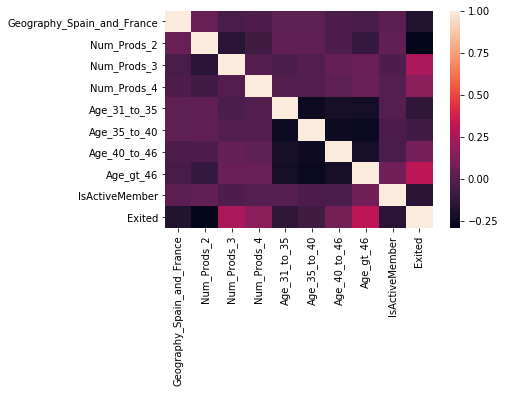

In [54]:
sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)